# Scanpy/PAGA - Adult

- Goal: import pre-processed data from Seurat to Scanpy and run PAGA
- Reference: https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html
- Convert from Seurat: https://github.com/LuckyMD/Code_snippets/blob/master/Seurat_to_anndata.ipynb
***

*Import libraries*

In [86]:
import os
import fa2
import sys
import loompy
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.0


*Set parameters*

In [87]:
# Change directory
os.getcwd()
os.chdir('/Users/rmevel/jupyter/scanpy_mevel_et_al/sc_adult_dataset/paga_all_epithelial/')

In [88]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(4,4))
results_file = './write/Mevel_et_al_sc_adult.h5ad'

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.0


## Load data

We use the loom file generated using `as.loom` from Seurat. Use scVelo to import seurat object as `read_loom` is failing in scanpy.  
__Important:__ Make sure the file is not used somewhere else (R or other notebook) as this will cause it to fail opening.

In [89]:
# scanpy read function
adata = sc.read_loom("/Users/rmevel/r/sc_mevel_et_al/sc_adult_dataset/loom/mevel_et_al_sc_adult.loom")

In [90]:
# Print content
adata

AnnData object with n_obs × n_vars = 3825 × 2000 
    obs: 'Cell', 'ClusterID', 'ClusterName', 'in_silico_clusters', 'lobe', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'population', 'rfp', 'seurat_clusters', 'treatment'
    var: 'Selected'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'scale_data'

**Reorder in_silico_clusters variable**

In [91]:
adata.obs['in_silico_clusters']

AAACCCAGTACAGGTG_1    Lum-D
AAAGAACGTTCGTGCG_1      Bas
AAAGTCCCACACACGC_1      Bas
AACCACAAGCGTCGAA_1    Lum-D
AACCTGAGTCTATGAC_1    Lum-D
                      ...  
TTTGGAGGTACGAGCA_3      Bas
TTTGGAGGTTTATGCG_3    Lum-A
TTTGGTTGTTTCACTT_3      Bas
TTTGTTGAGCGGCTCT_3      Bas
TTTGTTGTCATACGGT_3    Lum-F
Name: in_silico_clusters, Length: 3825, dtype: object

In [92]:
adata.obs.in_silico_clusters = adata.obs.in_silico_clusters.astype('category')
adata.obs.in_silico_clusters.cat.reorder_categories(['Lum-A', 'Lum-B', 'Lum-C', 'Lum-D', 'Lum-E', 'Lum-F','Bas'], inplace = True)

In [93]:
adata.obs.in_silico_clusters

AAACCCAGTACAGGTG_1    Lum-D
AAAGAACGTTCGTGCG_1      Bas
AAAGTCCCACACACGC_1      Bas
AACCACAAGCGTCGAA_1    Lum-D
AACCTGAGTCTATGAC_1    Lum-D
                      ...  
TTTGGAGGTACGAGCA_3      Bas
TTTGGAGGTTTATGCG_3    Lum-A
TTTGGTTGTTTCACTT_3      Bas
TTTGTTGAGCGGCTCT_3      Bas
TTTGTTGTCATACGGT_3    Lum-F
Name: in_silico_clusters, Length: 3825, dtype: category
Categories (7, object): [Lum-A, Lum-B, Lum-C, Lum-D, Lum-E, Lum-F, Bas]

Let us work with a higher precision than the default ‘float32’ to ensure exactly the same results across different computational platforms.

In [94]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

Define sample colors

In [95]:
adata.uns['rfp_colors'] = ["#ea4749", "#479bea"]
adata.uns['treatment_colors'] = ["#a1e186", "#b9006e"]
adata.uns['in_silico_clusters_colors'] = ["#B2B8E0", "#4A6FE3", "#1037AA", "#D33F6A", "#EF9708", "#F0B98D", "#8DD593"]

Check presence of dimensionally reduced data, and plot umap

In [96]:
adata.uns

OrderedDict([('rfp_colors', ['#ea4749', '#479bea']),
             ('treatment_colors', ['#a1e186', '#b9006e']),
             ('in_silico_clusters_colors',
              ['#B2B8E0',
               '#4A6FE3',
               '#1037AA',
               '#D33F6A',
               '#EF9708',
               '#F0B98D',
               '#8DD593'])])

In [97]:
adata.obsm

AxisArrays with keys: pca_cell_embeddings, umap_cell_embeddings

... storing 'ClusterName' as categorical
... storing 'lobe' as categorical
... storing 'orig_ident' as categorical
... storing 'population' as categorical
... storing 'rfp' as categorical
... storing 'seurat_clusters' as categorical
... storing 'treatment' as categorical


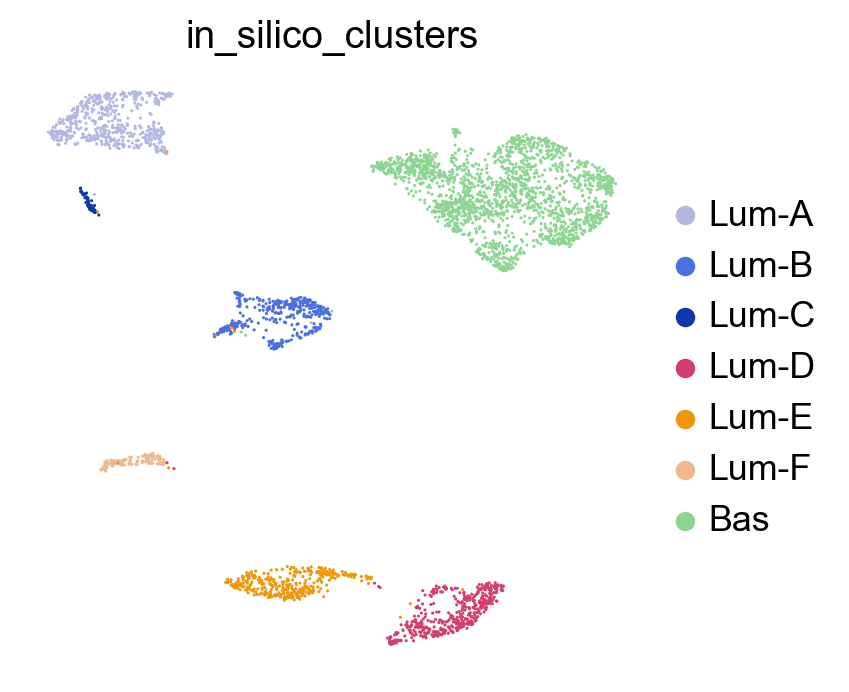

In [98]:
sc.pl.embedding(adata, basis='umap_cell_embeddings', color=['in_silico_clusters'], size=5, save=True)

Save a secondary object for later use if required

In [99]:
import copy
sdata = copy.deepcopy(adata)

In [100]:
### Use this if need to copy object back
adata = copy.deepcopy(sdata)

## Pre-process

Calculate neighbour graph using pre-computed PCA

In [101]:
sc.pp.neighbors(adata, n_neighbors=50, use_rep='pca_cell_embeddings', random_state=123)

computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)


## Perform PAGA

### Compute PAGA

In [102]:
sc.tl.paga(adata, groups='in_silico_clusters')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


### Make cluster graph layout

--> added 'pos', the PAGA positions (adata.uns['paga'])


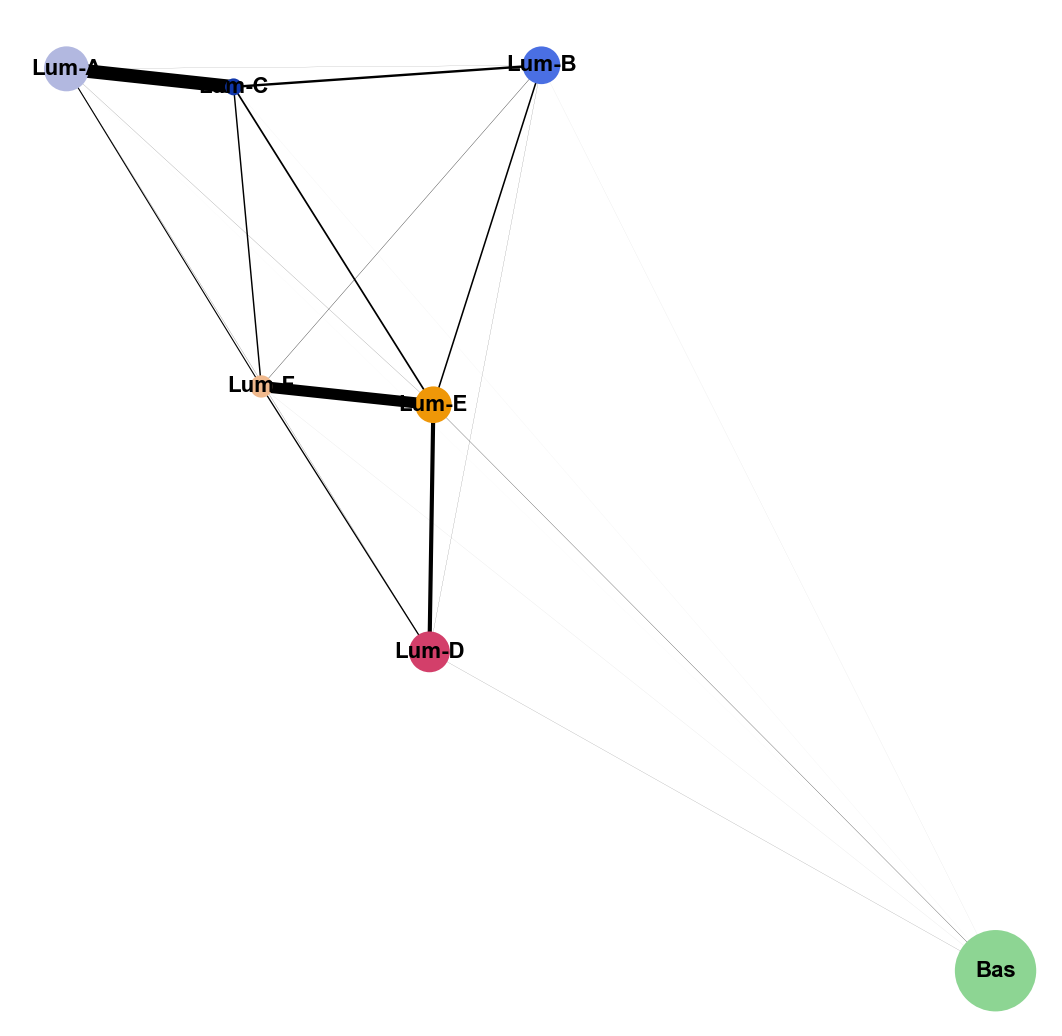

In [103]:
rcParams['figure.figsize'] = 6,6
sc.pl.paga(adata, plot=True, color=['in_silico_clusters'], 
           node_size_scale=1, node_size_power=1, edge_width_scale=1,
           fontsize=8, save=False, threshold=0.0)

--> added 'pos', the PAGA positions (adata.uns['paga'])


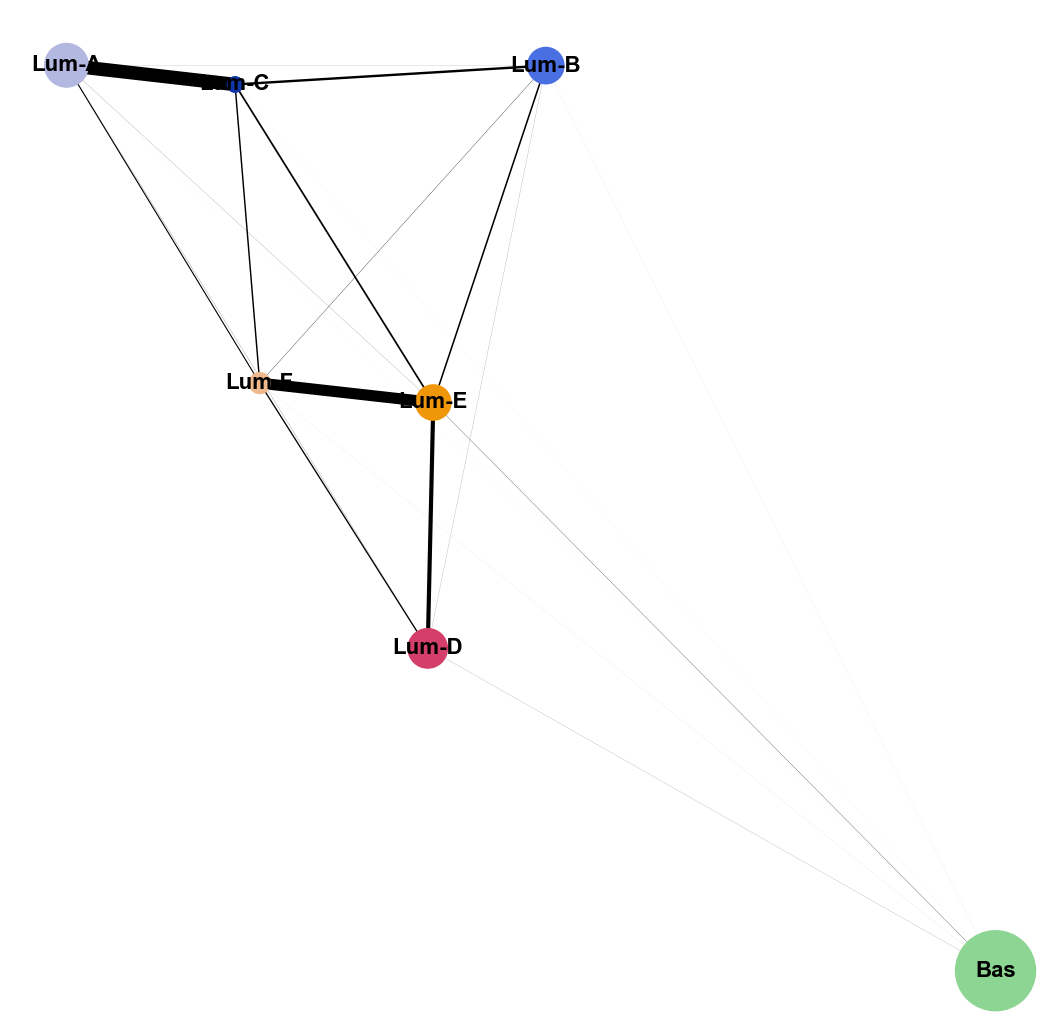

In [104]:
rcParams['figure.figsize'] = 6,6
sc.pl.paga(adata, plot=True, color=['in_silico_clusters'], 
           node_size_scale=1, node_size_power=1, edge_width_scale=1,
           fontsize=8, save=True, threshold=0.0)

In [105]:
adata.uns['paga']

{'connectivities': <7x7 sparse matrix of type '<class 'numpy.float64'>'
 	with 40 stored elements in Compressed Sparse Row format>,
 'connectivities_tree': <7x7 sparse matrix of type '<class 'numpy.float64'>'
 	with 6 stored elements in Compressed Sparse Row format>,
 'groups': 'in_silico_clusters',
 'pos': array([[-0.89322331, -2.93929955],
        [ 2.01195142, -2.94133179],
        [ 0.1285582 , -3.06013442],
        [ 1.29645647, -6.60727662],
        [ 1.33042568, -5.06064008],
        [ 0.27832919, -4.93870046],
        [ 4.73815835, -8.63510174]])}

### UMAP

In [106]:
sc.tl.umap(adata, init_pos='paga', min_dist=0.3, random_state=123)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


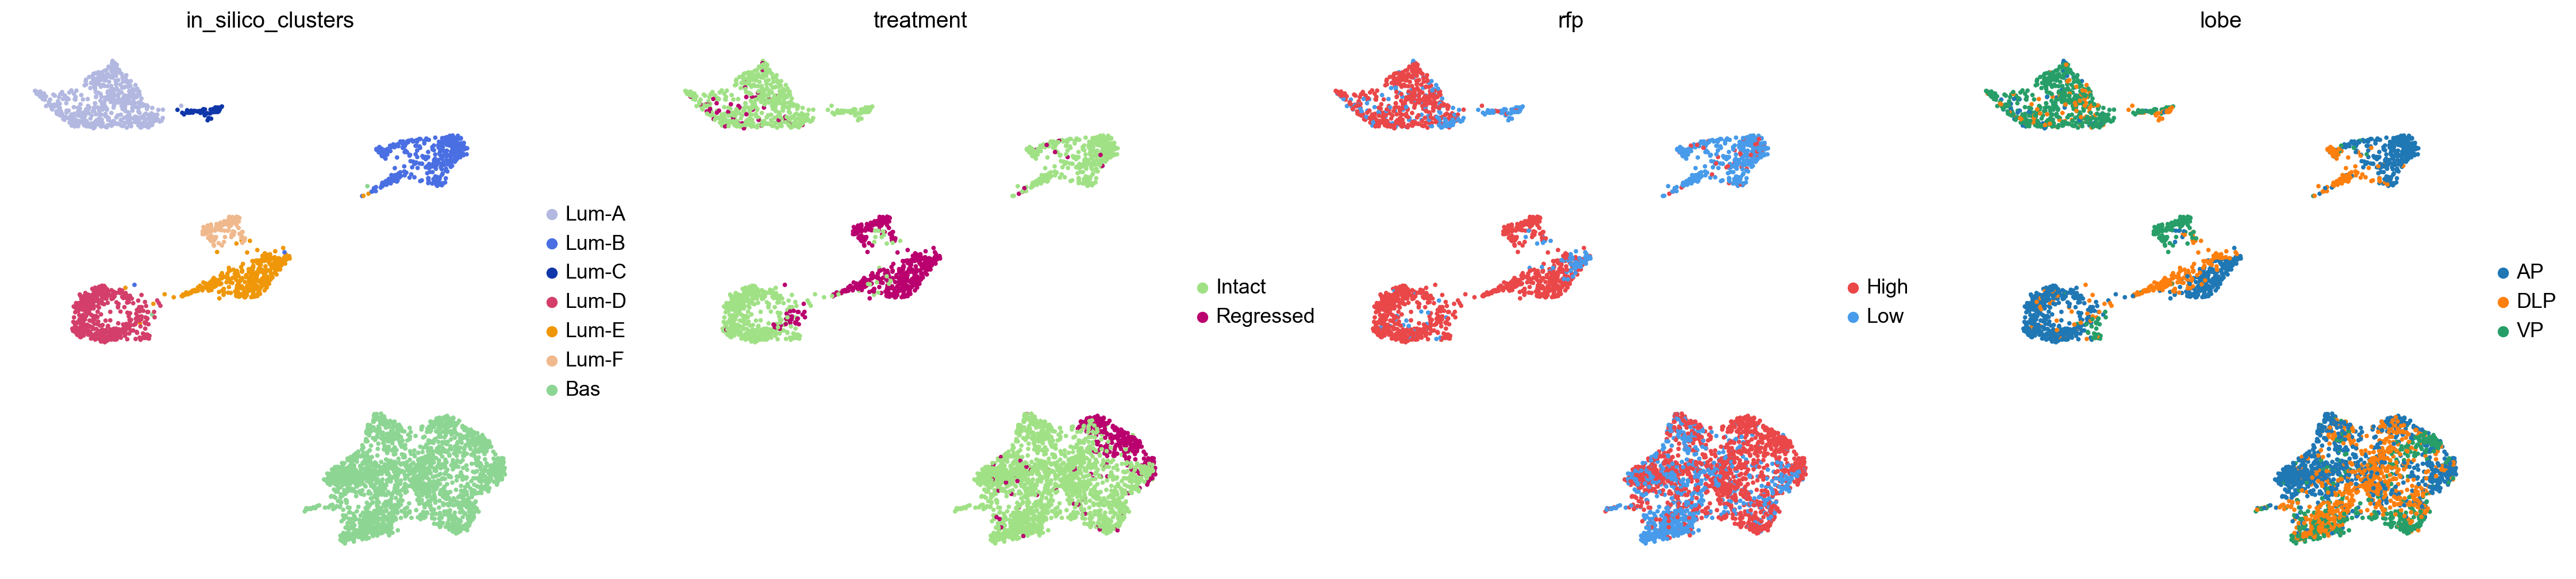

In [107]:
sc.pl.umap(adata, color=['in_silico_clusters', 'treatment','rfp', 'lobe'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


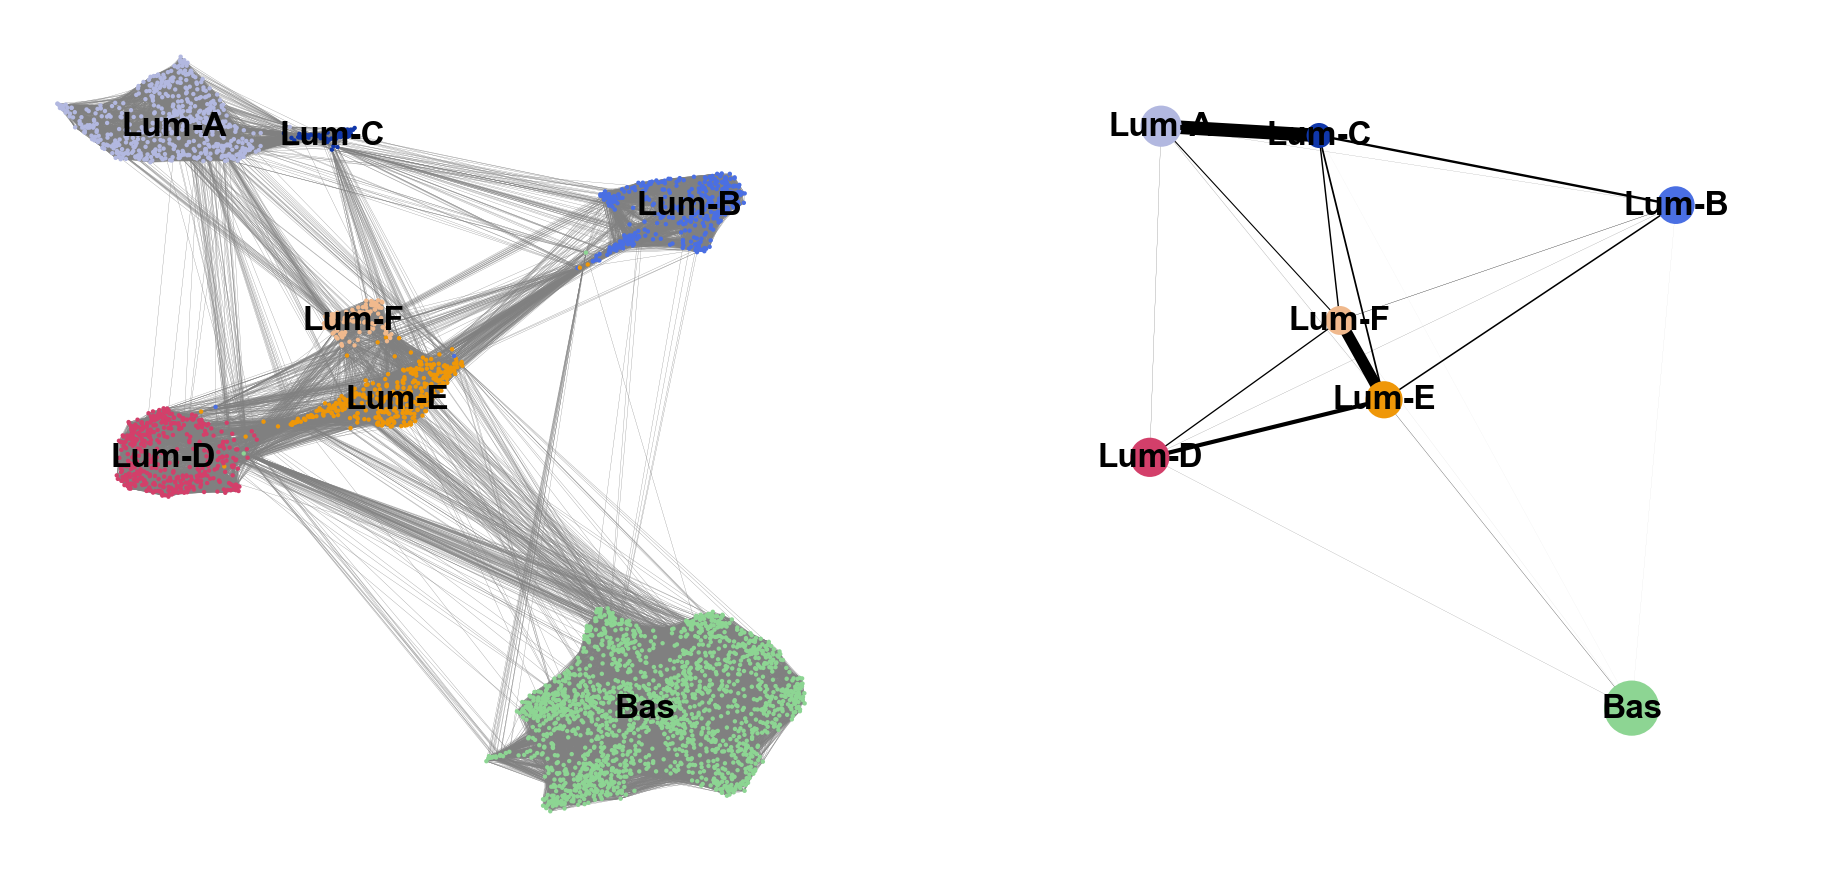

In [108]:
rcParams['figure.figsize'] = 5,5
sc.pl.paga_compare(
    adata, threshold=0.0, title='', right_margin=0.2, size=10, edge_width_scale=1,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

Save positions

In [109]:
pos = adata.uns['paga']['pos']
np.savetxt('pos.umap.csv', pos, delimiter=',')
#pos = np.loadtxt('pos.csv', delimiter=',')

**Note: it seems to be crucial to end plotting here, as the last versirandom_state=plot gets saved in** `adata.uns['paga']['pos']`.   
What we export after this, will consist in the PAGA of the Force Atlas layout, and the Force Atlas layout itself.

## Export

Follow script available here: https://lazappi.github.io/phd-thesis-analysis/05-paga.html

In [110]:
import os
import json

In [111]:
out_dir = 'output_umap/paga'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

def con2edges(con, names=None, sparse=True):
    print('Converting connectivity matrix to edges...')
    n = con.shape[0]
    edges = pd.DataFrame(columns=['From', 'To', 'Connectivity'])

    for i in range(n):
        for j in range(i + 1, n):
            if names is not None:
                fr = names[i]
                to = names[j]
            else:
                fr = str(i)
                to = str(j)

            connectivity = con[i, j]
            if sparse and connectivity == 0:
                continue

            entry = {'From' : fr, 'To' : to,
                     'Connectivity' : con[i, j]}
            edges = edges.append(entry, ignore_index=True)

    return edges

print('Outputting cluster edges...')
clust_con = adata.uns['paga']['connectivities'].toarray()
clust_edges = con2edges(clust_con)
clust_edges.to_csv(os.path.join(out_dir, 'cluster_edges.csv'),
                   index=False)

print('Outputting cluster tree edges...')
clust_tree_con = adata.uns['paga']['connectivities_tree'].toarray()
clust_tree_edges = con2edges(clust_tree_con)
clust_tree_edges.to_csv(os.path.join(out_dir, 'cluster_tree_edges.csv'),
                        index=False)

print('Outputting cluster embedding...')
clust_embedding = pd.DataFrame(adata.uns['paga']['pos'], columns=['X', 'Y'])
clust_embedding['in_silico_clusters'] = range(clust_embedding.shape[0])
clust_embedding = clust_embedding[['in_silico_clusters', 'X', 'Y']]

clust_embedding.to_csv(os.path.join(out_dir, 'cluster_embedding.csv'),
                       index=False)

print('Outputting cell edges...')
cells = adata.obs['Cell']
cell_con = adata.uns['neighbors']['connectivities']
cell_edges = pd.DataFrame(columns=['From', 'To', 'Connectivity'])
n_rows = len(cell_con.indptr)

for i in range(len(cell_con.indptr) - 1):
    row_ind = cell_con.indices[cell_con.indptr[i]:cell_con.indptr[i + 1]]
    print(f'\r\tRow {i} of {n_rows}', end='')
    for k, j in enumerate(row_ind):
        if j > i:
            con = cell_con.data[cell_con.indptr[i] + k]
            fr = cells[i]
            to = cells[j]
            entry = {'From' : fr, 'To' : to, 'Connectivity' : con}
            cell_edges = cell_edges.append(entry, ignore_index=True)
print('\n')

cell_edges.to_csv(os.path.join(out_dir, 'cell_edges.csv'),
                  index=False)

print('Outputting cell embedding...')
x = adata.obsm['X_umap'][:, 0]
y = adata.obsm['X_umap'][:, 1]
cell_embedding = pd.DataFrame({'Cell' : cells, 'X' : x, 'Y' : y})
cell_embedding.to_csv(os.path.join(out_dir, 'cell_embedding.csv'),
                      index=False)

print('Done!')

Outputting cluster edges...
Converting connectivity matrix to edges...
Outputting cluster tree edges...
Converting connectivity matrix to edges...
Outputting cluster embedding...
Outputting cell edges...
	Row 3824 of 3826

Outputting cell embedding...
Done!
